# Import Packages

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Loading Dataset

In [2]:
data = pd.read_csv('our_data.csv').drop(columns=['Unnamed: 0'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   fasting blood sugar  159256 non-null  int64  
 1   Cholesterol          159256 non-null  int64  
 2   relaxation           159256 non-null  int64  
 3   serum creatinine     159256 non-null  float64
 4   dental caries        159256 non-null  int64  
 5   height(cm)           159256 non-null  int64  
 6   waist(cm)            159256 non-null  float64
 7   AST                  159256 non-null  int64  
 8   age                  159256 non-null  int64  
 9   Gtp                  159256 non-null  int64  
 10  smoking              159256 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 13.4 MB


# Data Splitting

In [3]:
from sklearn.model_selection import train_test_split

# Split the dataset into 70% training and 30% testing.
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# Analyses Response 

In [4]:
# from sklearn.preprocessing import RobustScaler

# # contineous data
# cont_data = data.drop(columns=['dental caries', 'smoking'])

# # Initialize the RobustScaler
# scaler = RobustScaler()

# # Fit and transform the continuous data
# data_robust_scaled = scaler.fit_transform(cont_data)
# data_robust_scaled = pd.DataFrame(data_robust_scaled, columns=cont_data.columns)
# # Add back the 'dental caries' and 'smoking' columns
# data_robust_scaled['dental caries'] = data['dental caries'].values
# data_robust_scaled['smoking'] = data['smoking'].values

tried removing outliers using robust scaler but failed!

In [5]:
# deal with the skewness of the data
train_data['Gtp'], _ = stats.boxcox(train_data['Gtp'] + 1e-9)
test_data['Gtp'], _ = stats.boxcox(test_data['Gtp'] + 1e-9)

In [6]:
# Function to remove outliers based on IQR
def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# contineous data
cont_data = data.drop(columns=['dental caries', 'smoking'])
# Remove outliers from the features of the train data but not the test data
train_data_cleaned = remove_outliers(train_data, cont_data.columns)

In [7]:
# normalize continuous features 
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data_cleaned)
train_data_scaled = pd.DataFrame(train_data_scaled, columns=train_data_cleaned.columns)

test_data_scaled = scaler.transform(test_data)
test_data_scaled = pd.DataFrame(test_data_scaled, columns=test_data.columns)

normalization was done as PCA is sensitive to the scale of the data

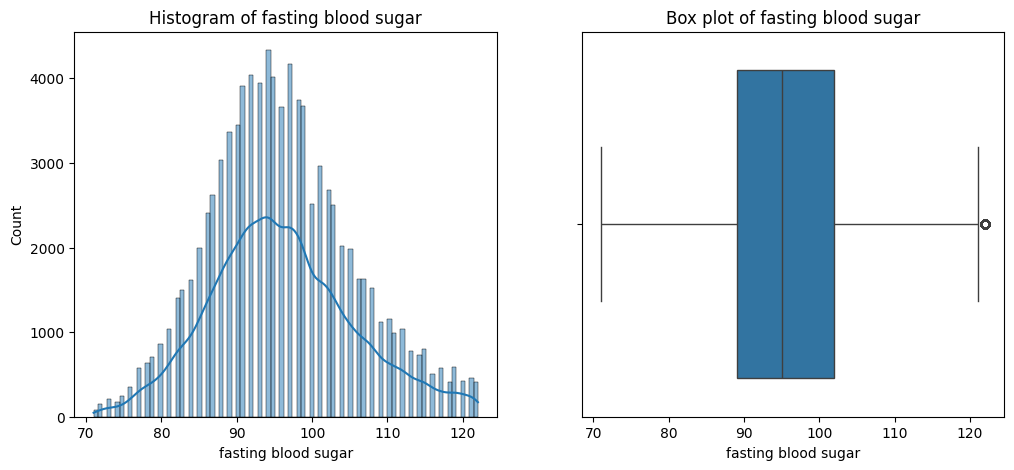

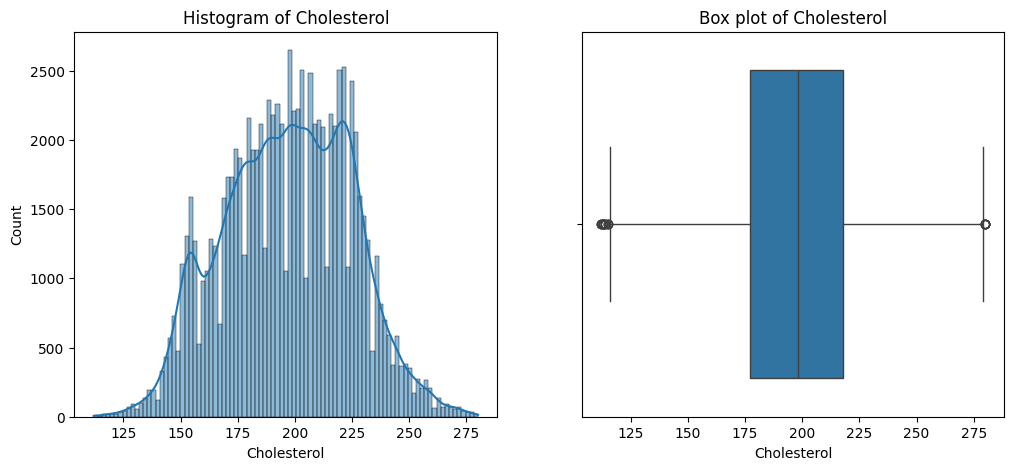

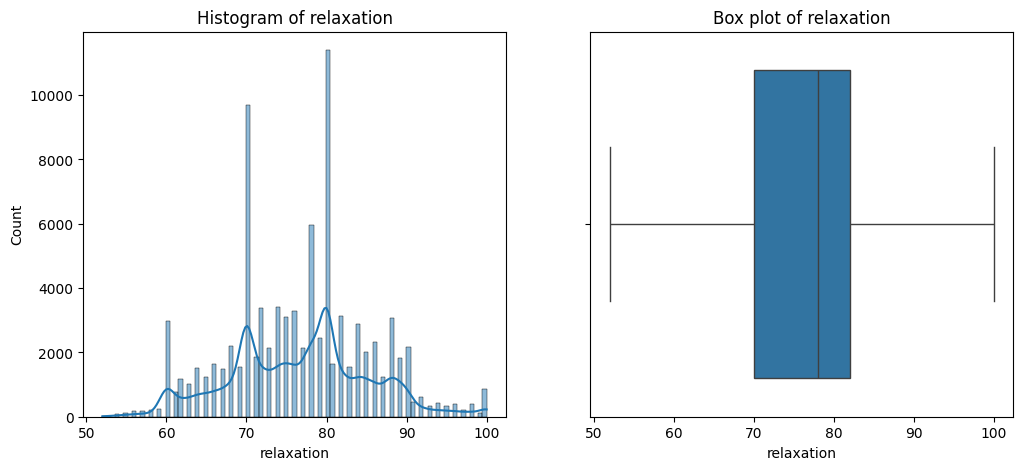

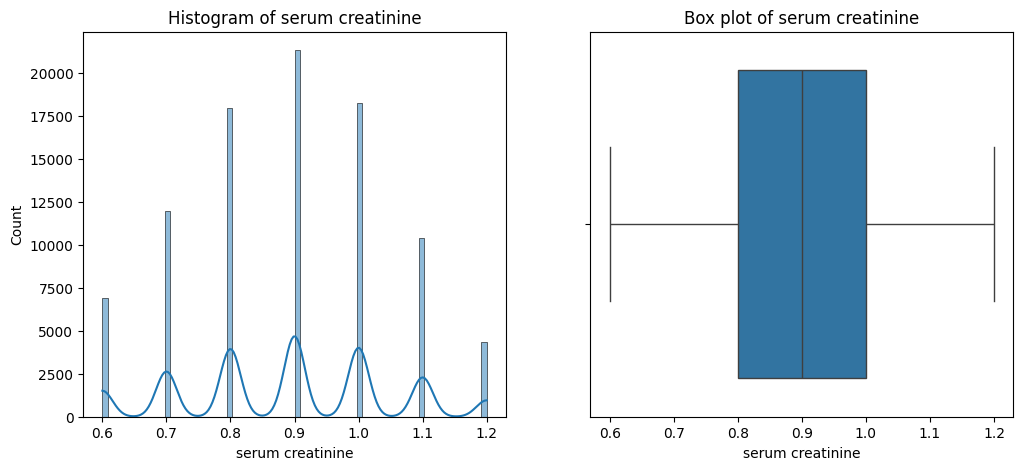

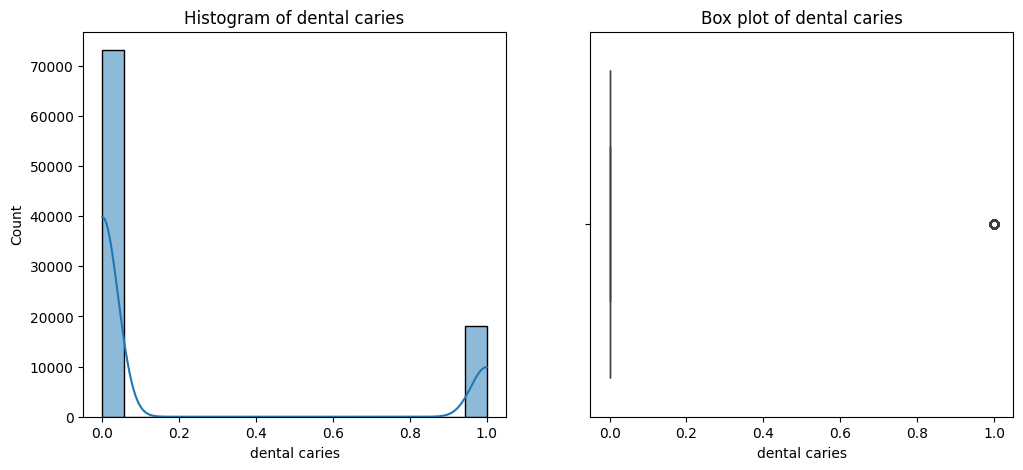

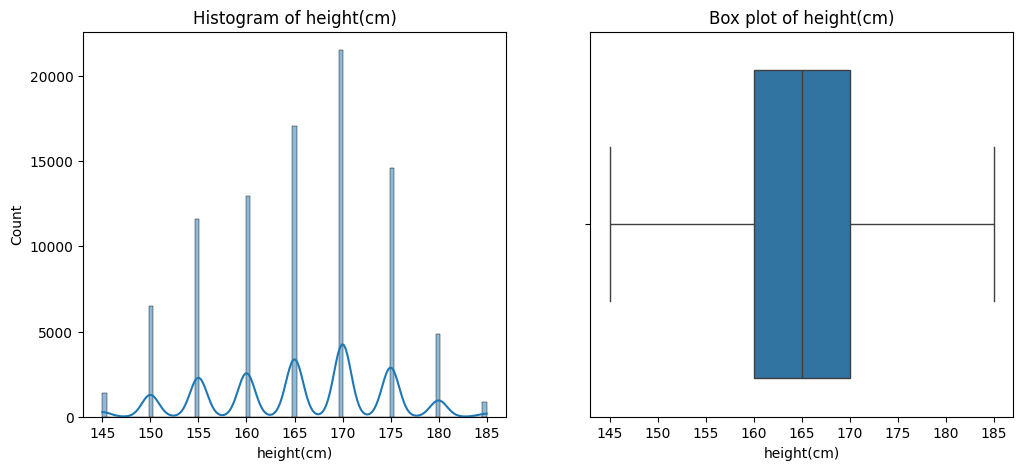

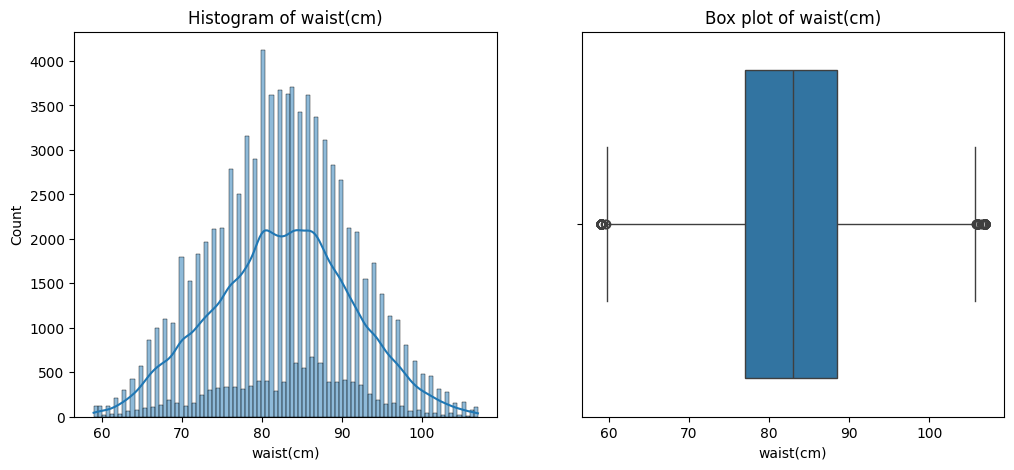

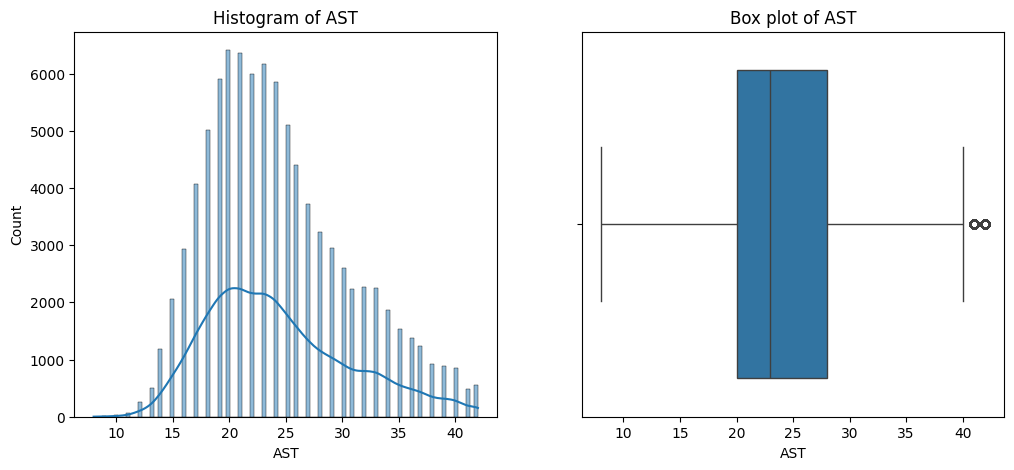

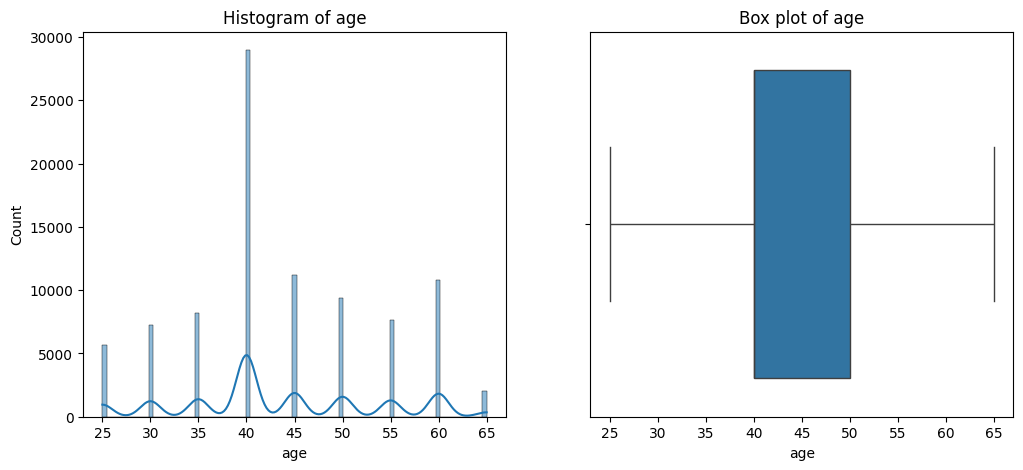

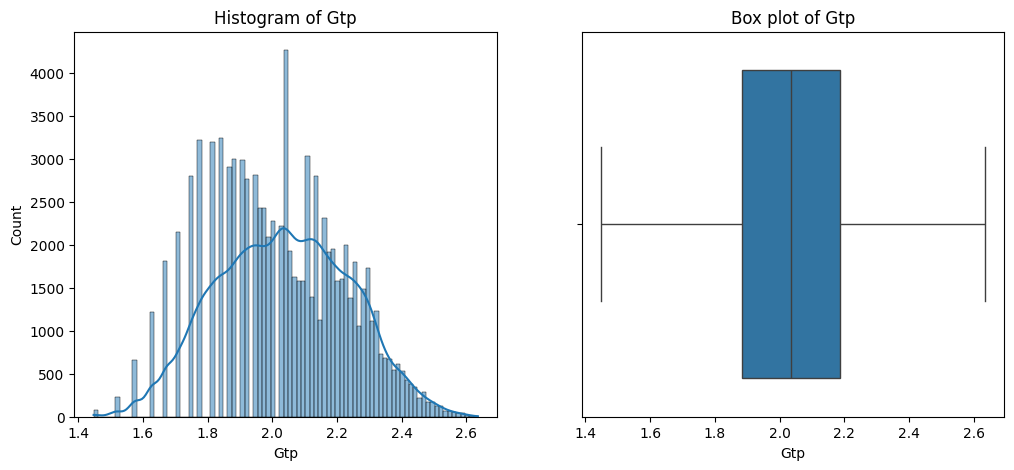

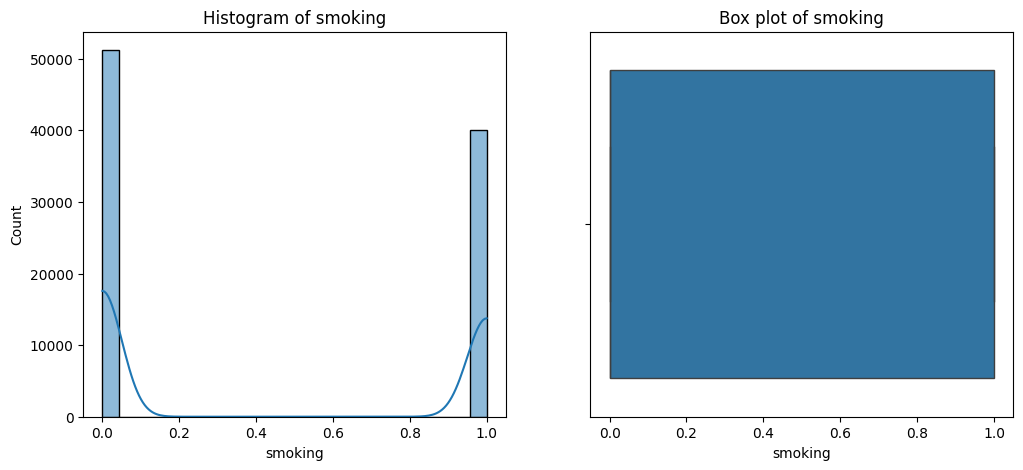

In [8]:
# Create histograms and box plots for each column
for column in train_data_cleaned.columns:
    plt.figure(figsize=(12, 5))
    
    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(train_data_cleaned[column], kde=True)
    plt.title(f'Histogram of {column}')
    
    # Box plot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=train_data_cleaned[column])
    plt.title(f'Box plot of {column}')
    
    plt.show()

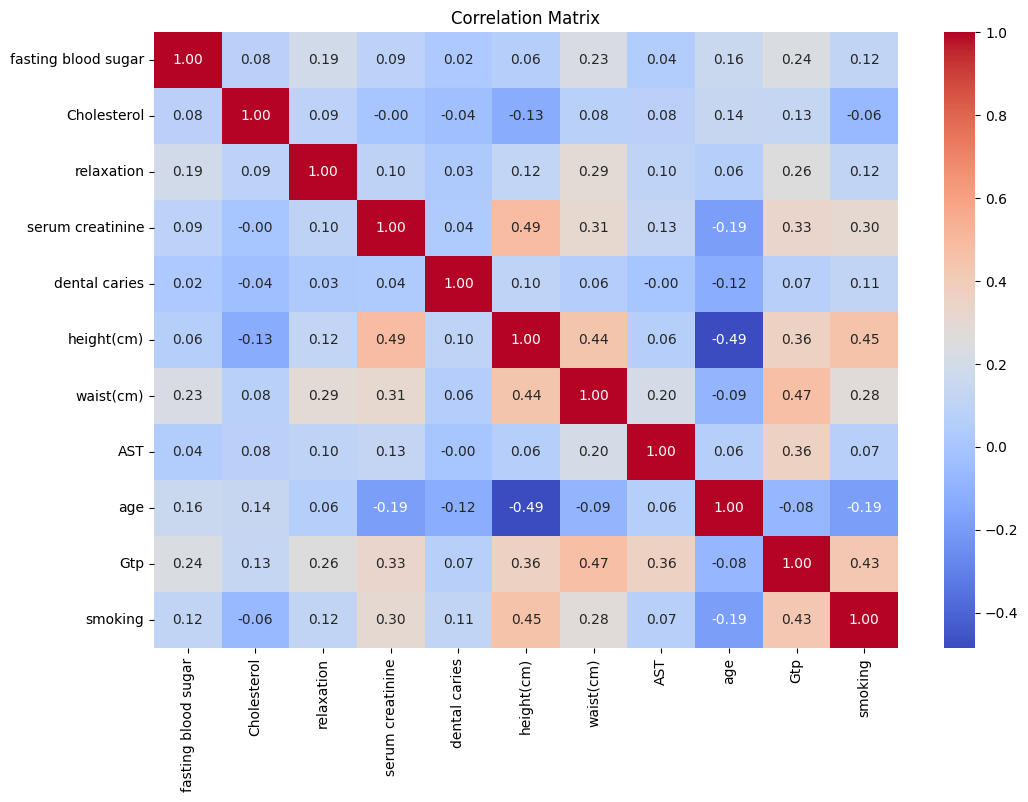

In [9]:
# Compute the correlation matrix
correlation_matrix = train_data_cleaned.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

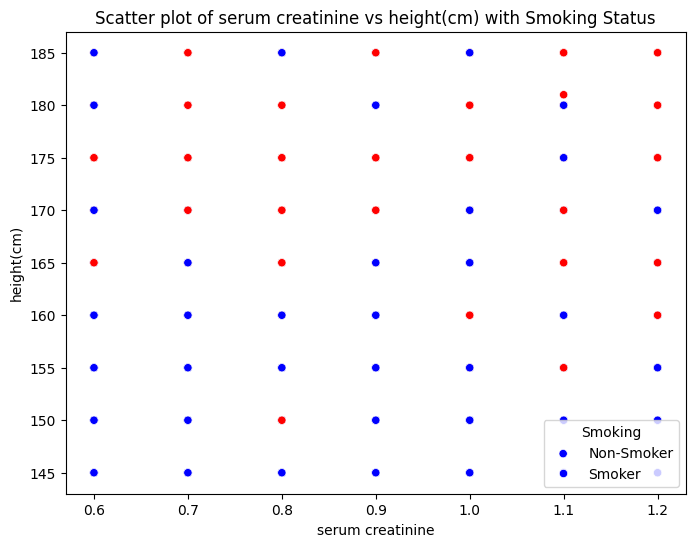

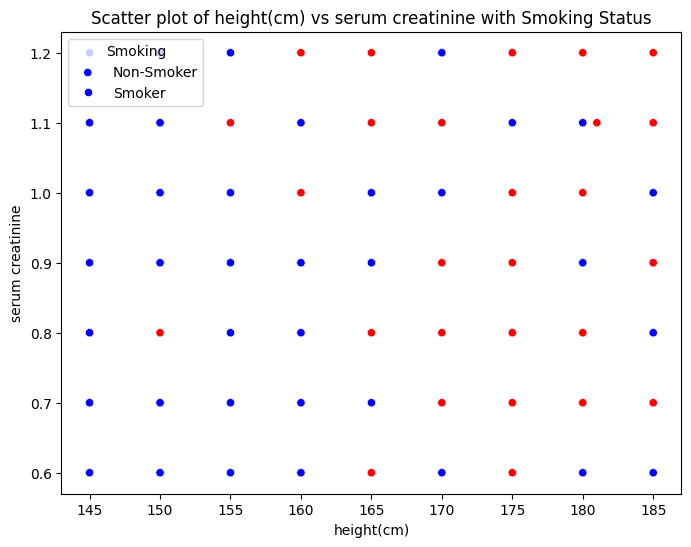

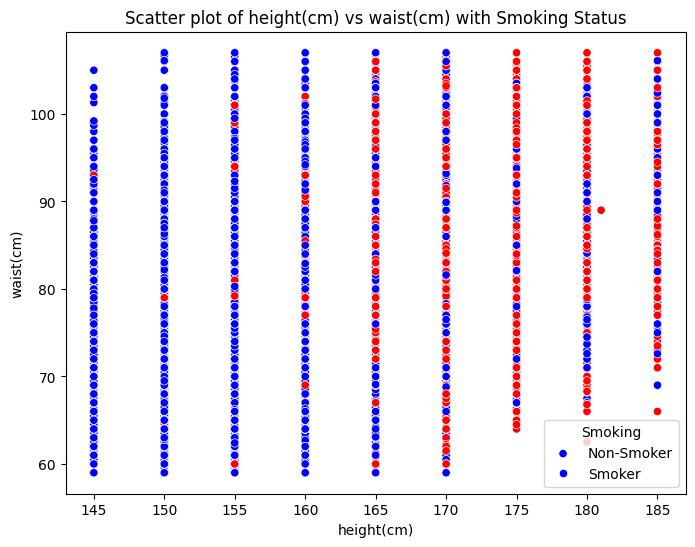

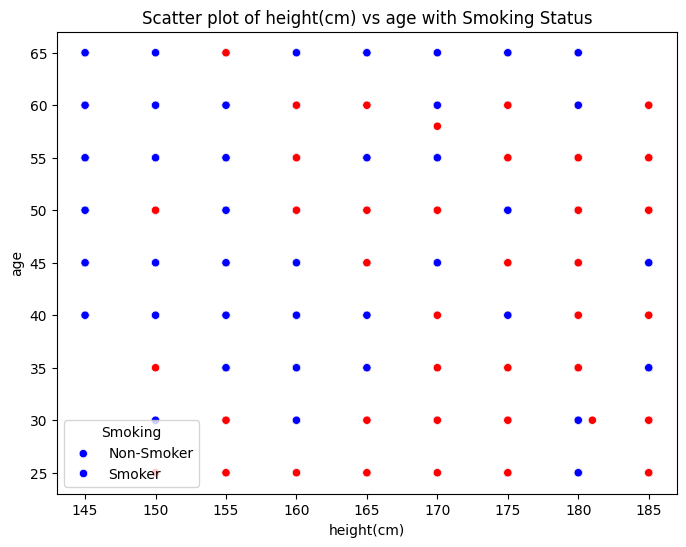

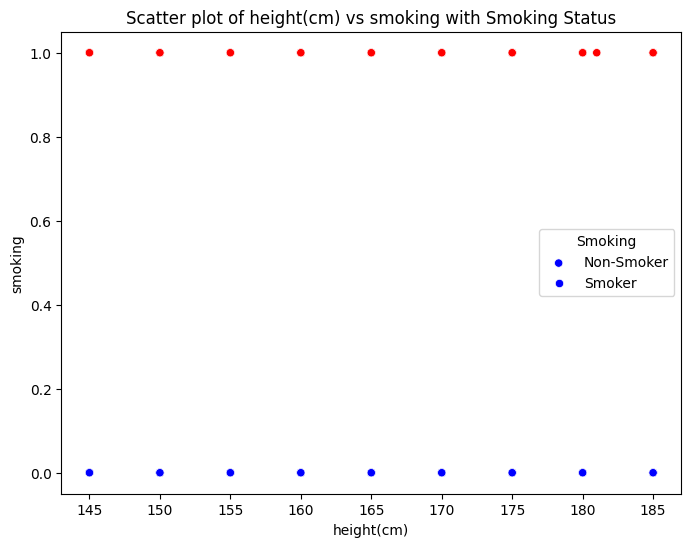

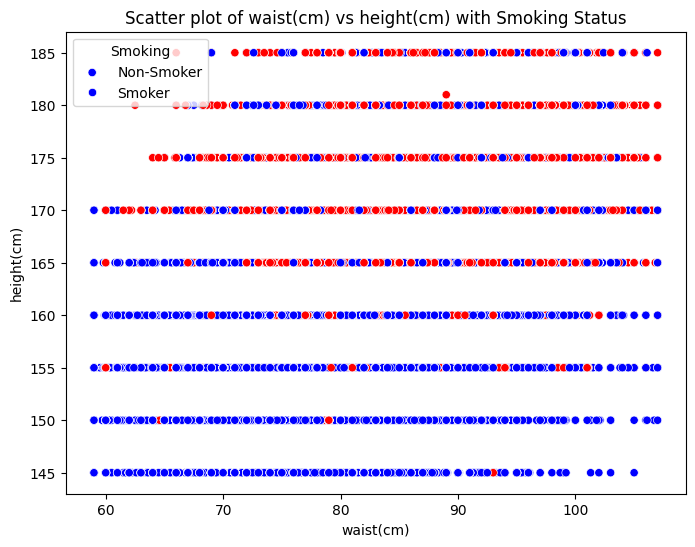

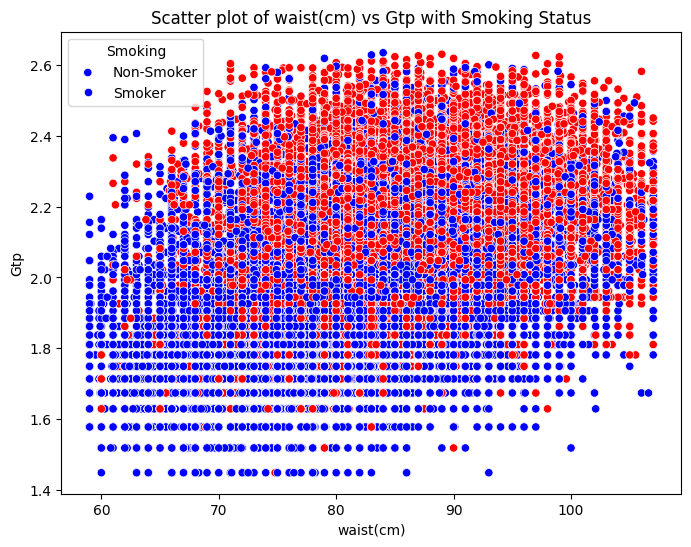

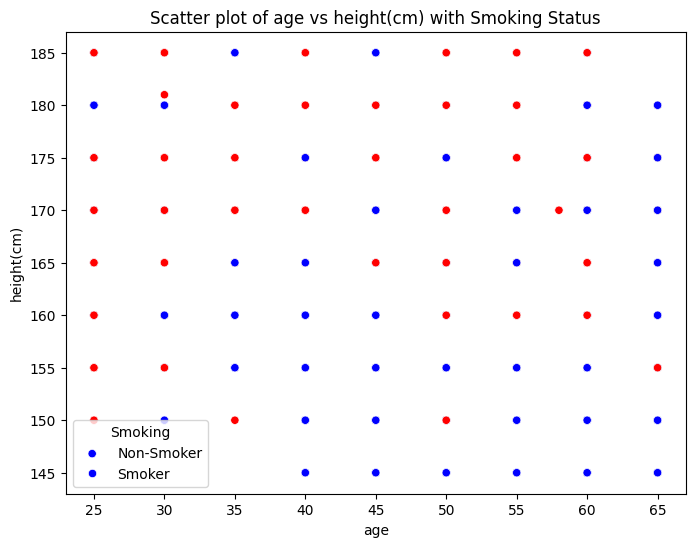

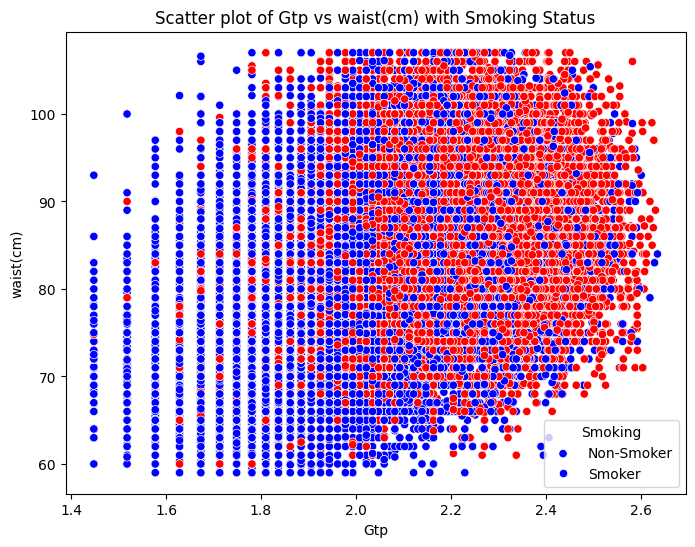

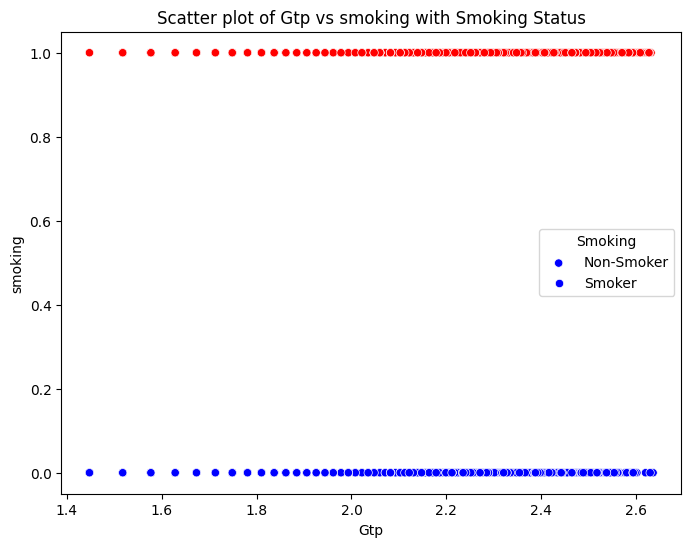

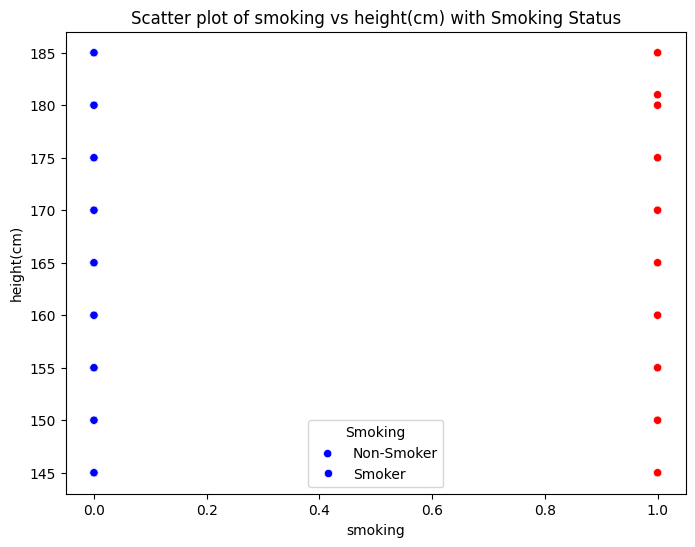

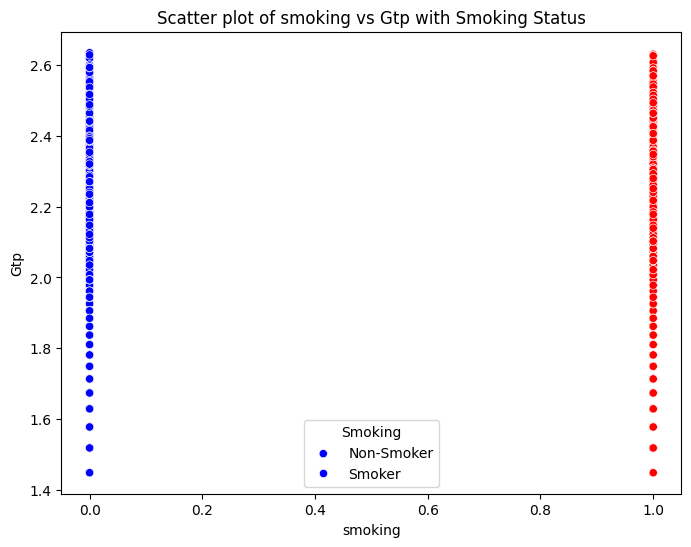

In [10]:
# Identify pairs of features with correlation higher than 0.4 or lower than -0.4
high_corr_pairs = correlation_matrix[(correlation_matrix > 0.4) | (correlation_matrix < -0.4)]

# Remove self-correlations
high_corr_pairs = high_corr_pairs[high_corr_pairs != 1]

# Get the pairs of features
pairs = high_corr_pairs.stack().index.tolist()

# Plot scatter plots for these pairs
for pair in pairs:
    feature1, feature2 = pair
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=train_data_cleaned[feature1], y=train_data_cleaned[feature2], hue=data['smoking'], palette={0: 'blue', 1: 'red'})
    plt.title(f'Scatter plot of {feature1} vs {feature2} with Smoking Status')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.legend(title='Smoking', labels=['Non-Smoker', 'Smoker'])
    plt.show()

The data is not correlated enough to drop some and keep some.

# Feature Engineering Using Multivariate Analysis

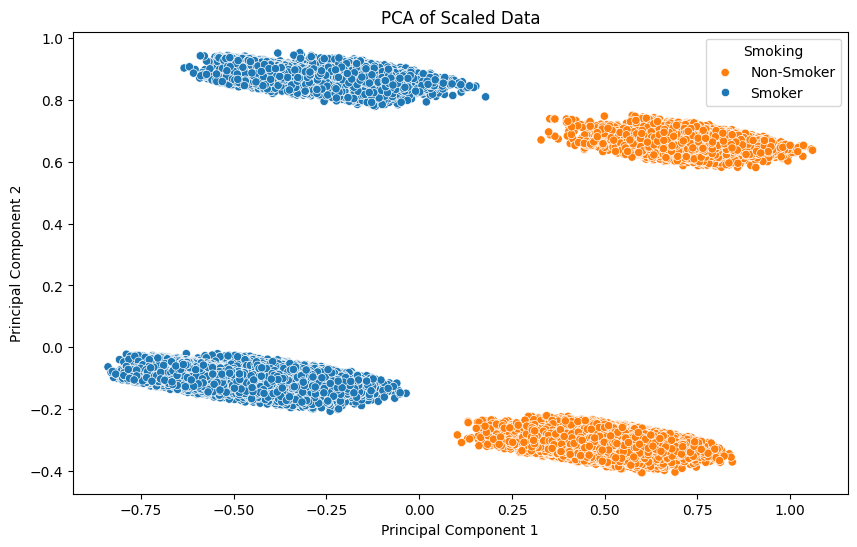

Explained variance by PC1 and PC2: [0.37335956 0.19864155 0.10646704 0.08907384]


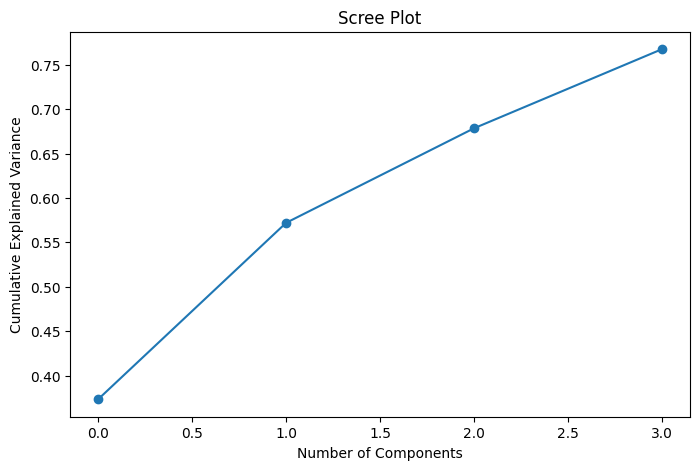

In [11]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=4)
principal_components = pca.fit_transform(train_data_scaled)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4'])
pca_df['smoking'] = train_data_scaled['smoking'].values

# Plot the PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='smoking', data=pca_df)
plt.title('PCA of Scaled Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Smoking', labels=['Non-Smoker', 'Smoker'])
plt.show()

# Explained variance
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by PC1 and PC2: {explained_variance}")

# Scree plot
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.show()

# Perform PCA with 4 components on test data
pca_test = PCA(n_components=4)  # 4 components
principal_components_test = pca_test.fit_transform(test_data_scaled)

# Create a DataFrame with the principal components
pca_test_df = pd.DataFrame(data=principal_components_test, columns=['PC1', 'PC2', 'PC3', 'PC4'])
pca_test_df['smoking'] = test_data_scaled['smoking'].values

Clustering shown in the scatter plot of the first two PC's indicates good PC's and the 4 PC's capture more than 0.75 the variance of the data. No standarization is needed to be done as PCA's are standarized already.

# Output

In [12]:
pca_df.to_csv('pca_train_df.csv', index=False)
pca_test_df.to_csv('pca_test_df.csv', index=False)


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Define the input features and target variable
X_pca = pca_df[['PC1', 'PC2']]
y_pca = data_scaled['smoking']

# Initialize the logistic regression model
log_reg = LogisticRegression()

# Split the PCA data into training and testing sets
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca, y_pca, test_size=0.3, random_state=42)

# Train the logistic regression model on the training set
log_reg.fit(X_pca_train, y_pca_train)

# Make predictions on the testing set
y_pca_pred = log_reg.predict(X_pca_test)

# Calculate the accuracy on the testing set
accuracy_pca_test = accuracy_score(y_pca_test, y_pca_pred)
print(f'Test Accuracy: {accuracy_pca_test:.4f}')
# Split the scaled data into training and testing sets
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(data_scaled.drop(columns=['smoking']), data_scaled['smoking'], test_size=0.2, random_state=42)

# Perform PCA on the training set
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

# Perform PCA on the testing set
X_test_pca = pca.transform(X_test_scaled)

# Initialize the logistic regression model
log_reg = LogisticRegression()

# Train the logistic regression model on the PCA-transformed training set
log_reg.fit(X_train_pca, y_train_scaled)

# Make predictions on the PCA-transformed testing set
y_test_pred = log_reg.predict(X_test_pca)

# Calculate the accuracy on the testing set
accuracy_test = accuracy_score(y_test_scaled, y_test_pred)
print(f'Test Accuracy: {accuracy_test:.4f}')

NameError: name 'data_scaled' is not defined